# To Do
- 斷詞系統jieba-> CKIPtagger
> https://ckip.iis.sinica.edu.tw/service/ckiptagger/


# 安裝與載入套件
- 使用 miniconda 的用戶需要多安裝一些套件

In [1]:
# conda install pandas
# !pip install git+https://github.com/APCLab/jieba-tw.git
# pip install pyLDAvis
# pip install sklearn
# conda install matplotlib
# conda install seaborn
# pip install python-igraph
# pip install cairocffi

In [1]:
import os
import gc
import re
import pandas as pd

import datetime
import igraph
import jieba
import pyLDAvis
import pyLDAvis.sklearn
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 轉換繁體
# from hanziconv import HanziConv
# 視覺化套件
from matplotlib.font_manager import FontProperties
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_rows', 1000)

# ------------- Crawler (2 mins) -------------

- 僅說明資料結構，爬蟲方法請參考部落格的文章

# ------------- SNA(10 mins) -------------

- 傳統找 KOL 的方法在技術發展的情況下遭遇了嚴峻的挑戰
    - [中國網軍519攻台駭進中油 我資安團隊激烈交戰擊退](https://news.ltn.com.tw/news/politics/breakingnews/3216715)
    - [網軍帶風向價碼 網站全都露](https://www.chinatimes.com/newspapers/20200626000332-260118?chdtv)
    - [抓到網軍！Twitter 永久刪除來自中、俄、土耳其的 3.2 萬個帳號](https://www.inside.com.tw/article/20053-twitter-removes-32k-accounts-tied-to-china-russia-turkey)
> 在帳號取得成本快速降低的條件下，我們需要更深入的進行分析才能找出KOL，在資訊技術的進步下(如文本生成、網軍)，傳統的留言數、按讚數等指標 已經不符合需求。

=====================================================

## 萃取互動資訊
- 互動資訊萃取方式
  - 看留言給誰，誰回復誰
  - 說明如何從原始資料萃取出互動的資訊

### 留言
檢視留言者與貼文者的互動

In [3]:
# # 讀取留言資料
# files = os.listdir('data/Comments')
# Comments = []
# for i in files:
#     ndf = pd.read_pickle('data/Comments/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'POSTID', 'COMMENTID']]
#     gc.collect()
#     print(i, ndf.shape)
#     Comments.append(ndf)
# Comments = pd.concat(Comments, ignore_index=True)
# Comments.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'POSTID', 'COMMENTID']

# # 透過 PostID, 追蹤貼文的 Author
# Posts = pd.read_pickle('data/politic_posts.pkl')
# Posts = Posts.loc[:,['NAME','PAGEID','POSTID','TIME','CONTENT']]
# Posts = Posts.drop_duplicates(ignore_index=True)
# Posts = Posts.loc[:,['NAME', 'PAGEID', 'POSTID']]
# Posts.columns = ['TARGET_NAME', 'TARGET', 'POSTID']
# Comments = pd.merge(Comments, Posts, how='left', on='POSTID')

# # 每則貼文最多萃取一次關聯
# Comments = Comments.drop_duplicates(['SOURCE_NAME', 'SOURCE', 'POSTID', 'TARGET_NAME', 'TARGET'], keep='first')
# Comments = Comments.loc[:,['SOURCE_NAME', 'SOURCE', 'TIME', 'TARGET_NAME', 'TARGET']]
# print(Comments.shape)
# Comments.to_pickle('data/Interactive/Interactive_Comments.pkl')
# del Comments

### 回覆 
檢視回覆者與留言者的互動

In [4]:
# # 讀取回覆資料
# files = os.listdir('data/Replies')
# Replies = []
# for i in files:
#     ndf = pd.read_pickle('data/Replies/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'PARENTCOMMENTID',]]
#     gc.collect()
#     print(i, ndf.shape)
#     Replies.append(ndf)
# Replies = pd.concat(Replies, ignore_index=True)
# Replies.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'PARENTCOMMENTID']
# Replies['PARENTCOMMENTID'] = Replies['PARENTCOMMENTID'].apply(lambda x: x.split('_',-1)[-1])
# Replies = Replies.drop_duplicates(keep='first')
# print(Replies.shape)

# # 透過 CommentID 追蹤回覆是給 留言的 Author 
# files = os.listdir('data/Comments')
# Comments = []
# for i in files:
#     ndf = pd.read_pickle('data/Comments/'+ i)
#     ndf = ndf.loc[:,['NAME', 'AUTHOR', 'COMMENTID']]
#     gc.collect()
#     print(i, ndf.shape)
#     Comments.append(ndf)
# Comments = pd.concat(Comments, ignore_index=True)
# Comments.columns = ['TARGET_NAME', 'TARGET', 'COMMENTID']
# Comments = Comments.drop_duplicates('COMMENTID', keep='first')
# print(Comments.shape)
# Comments.head(3)
# Replies = pd.merge(Replies, Comments, how='left', left_on='PARENTCOMMENTID', right_on='COMMENTID')

# # 每則留言最多萃取一次關聯
# Replies = Replies.drop_duplicates(['SOURCE_NAME', 'SOURCE', 'PARENTCOMMENTID', 'TARGET_NAME', 'TARGET'], keep='first')
# Replies = Replies.loc[:,['SOURCE_NAME', 'SOURCE', 'TIME', 'TARGET_NAME', 'TARGET']]
# Replies.to_pickle('data/Interactive/Interactive_Replies.pkl')
# print(Replies.shape)
# Replies.head(3)

In [4]:
# del Comments, Replies

In [4]:
# Interact = pd.concat([pd.read_pickle('data/Interactive/Interactive_Comments.pkl'),
#                       pd.read_pickle('data/Interactive/Interactive_Replies.pkl')],
#                      ignore_index = True)
# # 大選前 一個月
# # Interact = Interact.loc[Interact['TIME'].between('2019-12-11','2020-01-10',True),:]

# # 大選前二個月的資料
# Interact = Interact.loc[Interact['TIME'].between('2019-11-11','2020-01-10',True),:]

# Interact = Interact.groupby(['SOURCE_NAME', 'SOURCE','TARGET_NAME', 'TARGET']).size().reset_index()
# Interact.columns = ['SOURCE_NAME', 'SOURCE', 'TARGET_NAME', 'TARGET', 'WEIGHT']

# # 去除自我引用
# Interact = Interact.loc[Interact['SOURCE']!=Interact['TARGET'], :]
# print(Interact.shape)
# Interact.head(3)

(559763, 5)


,SOURCE_NAME,SOURCE,TARGET_NAME,TARGET,WEIGHT
0,Bill Leung,1471596177,蔡英文 Tsai Ing-wen,46251501064,1
1,'Ash Jackson,567327586,蔡英文 Tsai Ing-wen,46251501064,1
2,'Billy Li,100000851859077,蔡英文 Tsai Ing-wen,46251501064,1


## 節點重要性評估

=====================================================
- SNA如何評估節點重要性__透過 SNA 來從新認識KOL
    - degree(接觸人的數量/缺點是假賬號衝讚、分享數)
    - Closeness:計算到每個點到其他點的平均最短路徑，數字越小表示越在網絡的核心，距離其他節點的遠近程度(是否位在空間的中心位置)
    - betweeness:計算被經過的次數(必經之地如公文，在階級結構鮮明的組織較適合使用)
    - pagerank：將in-link視為具有聲望+遞迴計算。因為網站上面會有很多垃圾網站，為了避免被錯誤的估計重要性，導入了一個概念是「被重要的人引用應該比被不重要的人引用來的重要」。被假賬號的人留言，跟被蔡英文留言的意義完全不同
    - eigenvector:
    eigenvector_centrality
    eigenvector_centrality(directed=True, scale=True, weights=None, return_eigenvalue=False, arpack_options=None)
- Ref
    - [如何简单地理解中心度，什么是closeness、betweenness和degree](https://www.zhihu.com/question/22610633/answer/493452601)
    - [社区网络分析学习笔记 —— 算法实现及 igraph 介绍](https://zhuanlan.zhihu.com/p/40227203)
    - [学习笔记（1）：igraph 社区网络算法 分析《权力的游戏》Part 1](https://zhuanlan.zhihu.com/p/24881204)

=====================================================

In [4]:
# # 建立 vertex 清單
# vertices_a = Interact.loc[:,['SOURCE','SOURCE_NAME']]
# vertices_a.columns = ['VERTEX','VERTEX_NAME']
# vertices_b = Interact.loc[:,['TARGET','TARGET_NAME']]
# vertices_b.columns = ['VERTEX','VERTEX_NAME']
# vertices = pd.concat([vertices_a, vertices_b], ignore_index=True)
# vertices = vertices.drop_duplicates(['VERTEX'], keep='first')
# del vertices_a, vertices_b

In [5]:
# g = igraph.Graph(directed=True)

# # 加入 vertex 資訊
# for vertex in vertices['VERTEX']:
#     g.add_vertex(str(vertex))
    
# # 加入 node 的 label
# g.vs['label'] = vertices['VERTEX_NAME'].values
# # del vertices

In [9]:
# igraph.summary(g)

IGRAPH DN-- 347406 0 -- 
+ attr: label (v), name (v)


In [10]:
# # add edges
# edges = [(source, target) for source, target in zip(Interact['SOURCE'], Interact['TARGET'])]
# g.add_edges(edges)
# igraph.summary(g)

IGRAPH DN-- 347406 559763 -- 
+ attr: label (v), name (v)


In [19]:
# # add weights
# g.es['weight'] = Interact['WEIGHT'].values

In [20]:
# igraph.summary(g)

IGRAPH DNW- 347406 559763 -- 
+ attr: label (v), name (v), weight (e)


In [21]:
# g.write_pickle("sna_graph_data_L60D.pkl")

## 找出前 100 位KOL 

分析前 100 位 KOL 的四個重要性指標，看出有些人是 indegree 很高，有些是pagerank，有些的betweeness 
> 1. 不同產業/專案有不同的需求，需要依目的選擇合適的觀察指標
2. 由於 node 的數量非常多，在分析時將一些重要性較低的node/edge移除後能幫助我們看清楚網絡核心結構

=====================================================

In [7]:
# # degree
# g.vs['degree'] = g.vs.degree(mode='ALL', loops=False)

# # indegree
# g.vs['indegree'] = g.vs.degree(mode='IN', loops=False)

# # outdegree
# g.vs['outdegree'] = g.vs.degree(mode='OUT', loops=False)

# # betweeness
# g.vs['betweenness'] = g.vs.betweenness()

# # closeness
# g.vs['closeness'] = g.vs.closeness()

# # 計算 pagerank 值
# g.vs['pagerank'] = g.pagerank(vertices=None, 
#                               directed=True,
#                               weights='weight',
#                               niter=10000,
#                               eps=0.001)

In [8]:
# g.write_pickle("sna_graph_data_L60D.pkl")

In [2]:
g = igraph.Graph.Read_Pickle("sna_graph_data_L60D.pkl")

In [3]:
igraph.summary(g)

IGRAPH DNW- 347406 559763 -- 
+ attr: betweenness (v), closeness (v), degree (v), indegree (v), label (v), name (v), outdegree (v), pagerank (v), weight (e)


In [4]:
vertices_info = pd.DataFrame({'name':g.vs['name'],
                              'label':g.vs['label'],
                              'degree':g.vs['degree'],
                              'indegree':g.vs['indegree'],
                              'outdegree':g.vs['outdegree'],
                              'betweenness':g.vs['betweenness'],
                              'closeness':g.vs['closeness'],
                              'pagerank':g.vs['pagerank']})
vertices_info.head()

,name,label,degree,indegree,outdegree,betweenness,closeness,pagerank
0,1471596177,Bill Leung,1,0,1,0.0,0.013718,6.346806e-07
1,567327586,'Ash Jackson,1,0,1,0.0,0.013718,6.346806e-07
2,100000851859077,'Billy Li,1,0,1,0.0,0.013718,6.346806e-07
3,1660063953,'Vicky Lee',1,0,1,0.0,0.013718,6.346806e-07
4,100000258321181,'Wei Chi Lee',1,0,1,0.0,0.013718,6.346806e-07


In [5]:
cols = ['degree', 'indegree', 'outdegree', 'betweenness', 'closeness', 'pagerank']
for i in cols:
    vertices_info[i+'_nm'] = np.sqrt(vertices_info[i])
    vertices_info[i+'_nm'] = MinMaxScaler().fit_transform(vertices_info.loc[:,[i+'_nm']])
vertices_info['score'] = vertices_info['indegree_nm'] + vertices_info['outdegree_nm'] + vertices_info['betweenness_nm'] + vertices_info['closeness_nm'] + vertices_info['pagerank_nm']
kols = vertices_info.sort_values(by='score',ascending=False).head(40)
kols.head()

,name,label,degree,indegree,outdegree,betweenness,closeness,pagerank,degree_nm,indegree_nm,outdegree_nm,betweenness_nm,closeness_nm,pagerank_nm,score
263582,46251501064,蔡英文 Tsai Ing-wen,175113,175101,12,3.129599e+09,0.013908,0.320154,1.000000,1.000000,0.121342,1.000000,1.000000,1.000000,4.121342
347296,1863023523934803,韓國瑜,148885,148885,0,0.000000e+00,0.013878,0.082810,0.921888,0.922107,0.000000,0.000000,0.998893,0.507890,2.428889
2853,100000359856261,Allen Lee,18,9,9,3.114554e+09,0.013787,0.022680,0.007767,0.007169,0.105085,0.997593,0.995567,0.265123,2.370538
258441,100023374938298,蔡伟,51,9,42,3.110889e+09,0.013786,0.002144,0.014711,0.007169,0.227010,0.997006,0.995513,0.080532,2.307231
32996,100041581207571,Grande Li,817,2,815,1.453288e+08,0.013778,0.000003,0.066073,0.003380,1.000000,0.215492,0.995246,0.001817,2.215935


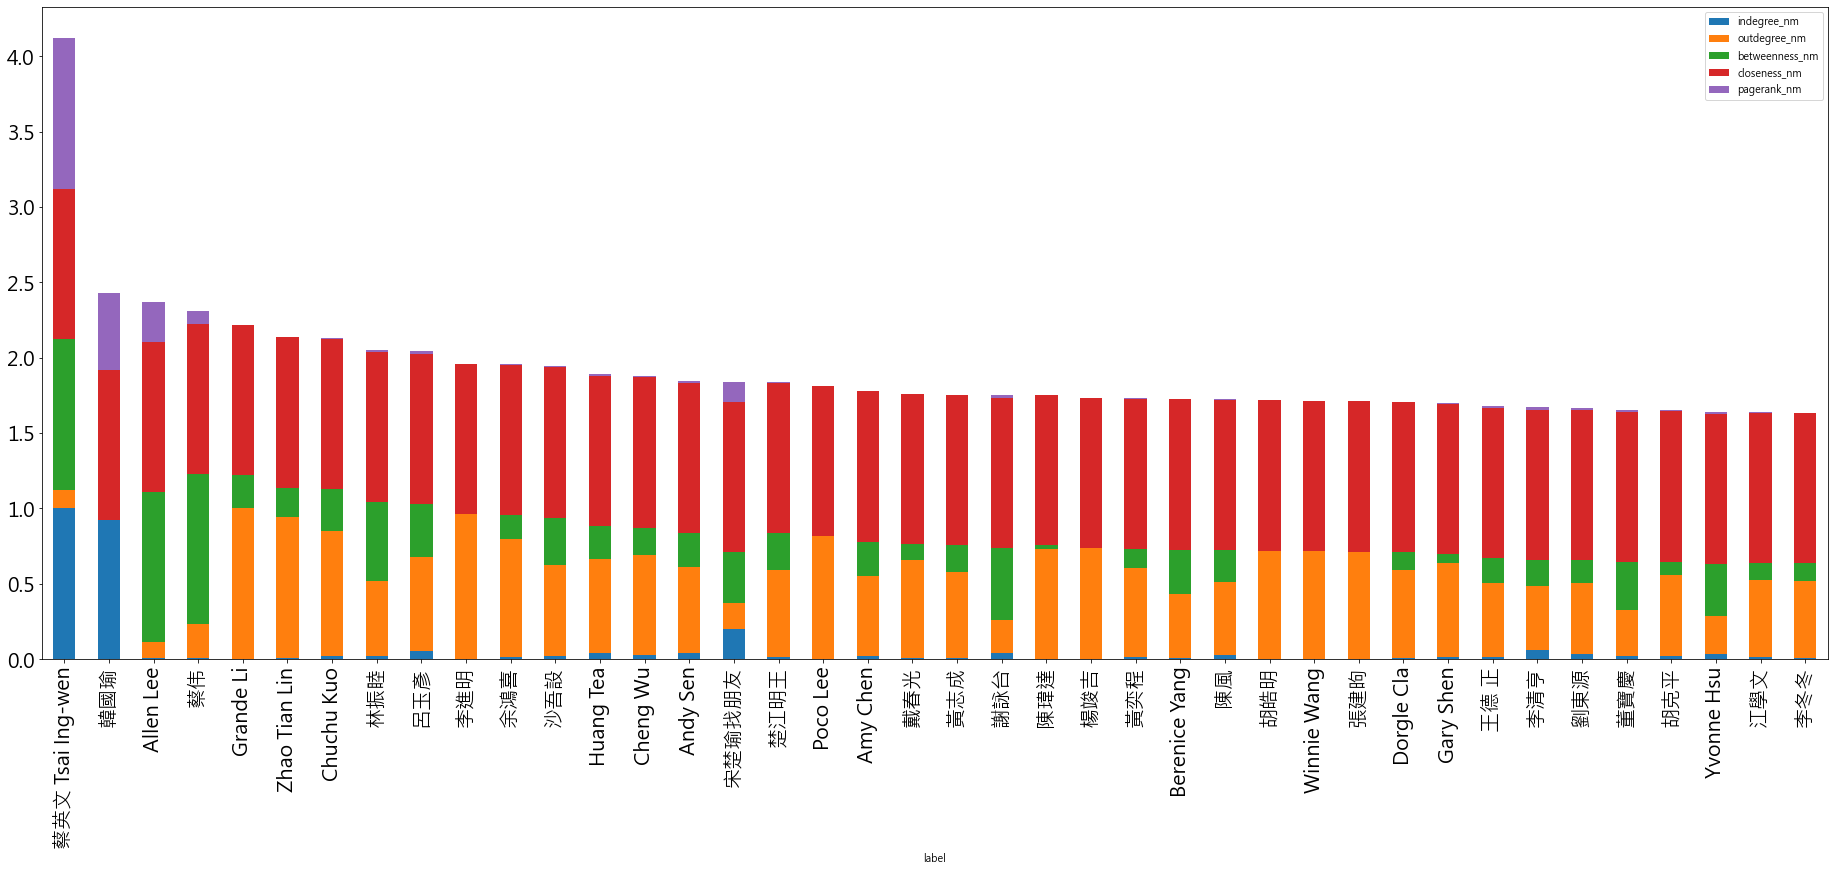

In [6]:
# sns.set()
plt.rcParams["figure.figsize"] = [32, 12]
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
kols.loc[:,['label', 'indegree_nm', 'outdegree_nm', 'betweenness_nm', 'closeness_nm', 'pagerank_nm']].set_index('label').plot(kind='bar', style='ggplot',stacked=True)

## KOL的互動行為
- 視覺化
    - 可以畫著100個KOL的互動情形，看是在各自的領域努力，還是彼此有很頻繁的互動
    - 候選人身邊有哪些KOL?
    > who is in your network, who is not?
    - 發現：韓的身邊也有KOL，但KOL其實是反對他的!(草包選總統XXX)
    > Can you combine the nominalist and the realist perspectives?

- 可以再依據社群上色，連結強度上寬度
- 把weight 太小的濾除

=====================================================

=====================================================
- 社群偵測(如果有需要、有幫助的話)
    > 調顏色
    > https://igraph.org/python/doc/tutorial/tutorial.html#layout-algorithms
    - [igraph 社交网络分析](http://rstudio-pubs-static.s3.amazonaws.com/484205_48e8ef6ea31b4bb7a11746c988da39de.html)
    
=====================================================

In [7]:
igraph.summary(g)

IGRAPH DNW- 347406 559763 -- 
+ attr: betweenness (v), closeness (v), degree (v), indegree (v), label (v), name (v), outdegree (v), pagerank (v), weight (e)


In [16]:
kols = vertices_info.sort_values(by='score',ascending=False)
# 過濾掉 indegree 太少的KOLS
kols = kols.loc[kols['indegree'].apply(lambda x: x>=20),:]
kols = kols.sort_values(by='pagerank_nm',ascending=False).head(100)
print(kols.shape)
kols.head(5)

(100, 15)


,name,label,degree,indegree,outdegree,betweenness,closeness,pagerank,degree_nm,indegree_nm,outdegree_nm,betweenness_nm,closeness_nm,pagerank_nm,score
263582,46251501064,蔡英文 Tsai Ing-wen,175113,175101,12,3.129599e+09,0.013908,0.320154,1.000000,1.000000,0.121342,1.000000,1.000000,1.000000,4.121342
347296,1863023523934803,韓國瑜,148885,148885,0,0.000000e+00,0.013878,0.082810,0.921888,0.922107,0.000000,0.000000,0.998893,0.507890,2.428889
242637,100009533631280,神原明野,160,159,1,9.351605e+05,0.013788,0.024872,0.027904,0.030134,0.035028,0.017286,0.995594,0.277706,1.355749
258419,100006855841686,蔡以誠,21,20,1,1.206660e+05,0.013788,0.024826,0.008582,0.010687,0.035028,0.006209,0.995586,0.277450,1.324962
67990,769328496,Mia Wang,48,47,1,3.189025e+05,0.013787,0.022693,0.014200,0.016383,0.035028,0.010094,0.995575,0.265201,1.322282


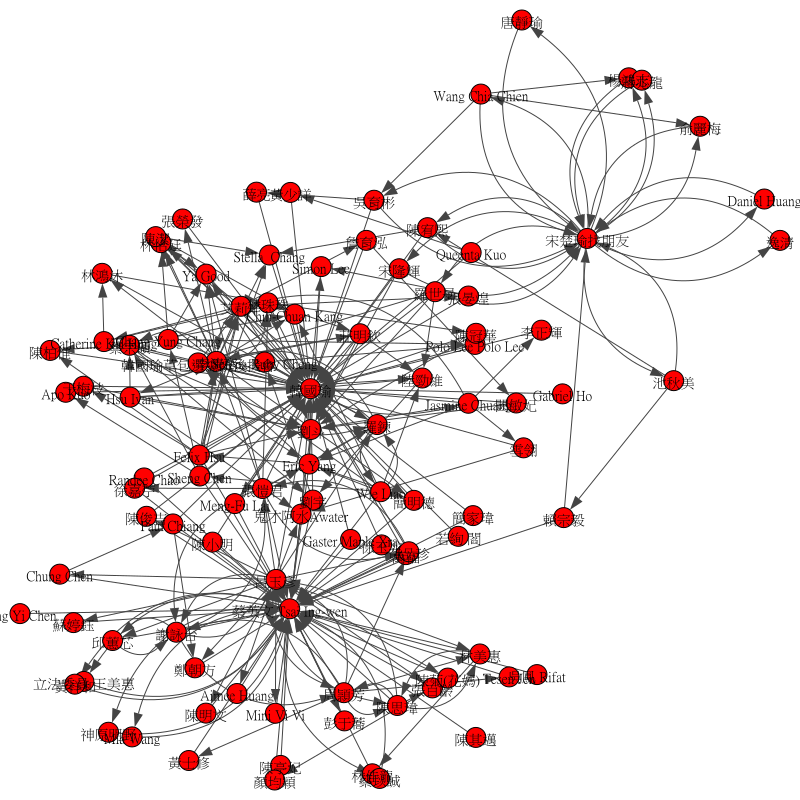

In [20]:
# kols = g.vs.select(pagerank_ge=0.000040)['name']
sg = g.subgraph(kols['name'])
layout = sg.layout("kk")
igraph.plot(sg, layout = layout,bbox=(0,0,800,800))

## 視覺化
- 先呈現整體樣貌+分群，看一下候選人的身邊的KOL數量，也進一步引出在身邊不一定就是支持，ex.草包選XXX
- 點的大小
- 點的顏色
- 邊的粗細/深淺

因為這邊都是KOL，其實每個KOL都有自己的故事! 在這邊可以挑一些個案來說明
> 發現：
1. 有些中國的賬號跑來，我們以為他是網軍假賬號，結果是真的人也有立場，他們主要是討厭蔡，但當韓對香港的事情表示譴責時，他也在罵韓，甚至說寧願要真小人不要偽君子(徐嘉苧)

In [19]:
modu = sg.community_infomap(edge_weights='weight', vertex_weights=None, trials=1000)
modu = sg.community_fastgreedy('weight')
# layout = modu.layout("kk")
igraph.plot(modu, layout = layout,bbox=(0,0,800,800))

NotImplementedError: Error at c:\projects\python-igraph-jst2e\vendor\build\igraph\igraph-0.9.0-pre+0afacadd-msvc\src\fast_community.c:641: fast greedy community detection works for undirected graphs only, Unimplemented function call

In [45]:
sg.community_optimal_modularity(weights=None)

NotImplementedError: Error at c:\projects\python-igraph-jst2e\vendor\build\igraph\igraph-0.9.0-pre+0afacadd-msvc\src\optimal_modularity.c:84: GLPK is not available, Unimplemented function call

In [47]:
sg.es[0]

igraph.Edge(<igraph.Graph object at 0x000001C31060F8B8>, 0, {'weight': 4})

In [48]:
sg.vs[0]

igraph.Vertex(<igraph.Graph object at 0x000001C31060F8B8>, 0, {'name': '100000319616052', 'label': 'Aimee Huang', 'pagerank': 0.00011305924522569616, 'degree': 265, 'betweenness': 3205336.736322965, 'closeness': 0.013788359585081924, 'indegree': 262, 'outdegree': 3})

In [25]:
modu = sg.community_optimal_modularity('weight')
igraph.plot(modu, layout = layout,bbox=(0,0,800,800))

NotImplementedError: Error at c:\projects\python-igraph-jst2e\vendor\build\igraph\igraph-0.9.0-pre+0afacadd-msvc\src\optimal_modularity.c:84: GLPK is not available, Unimplemented function call

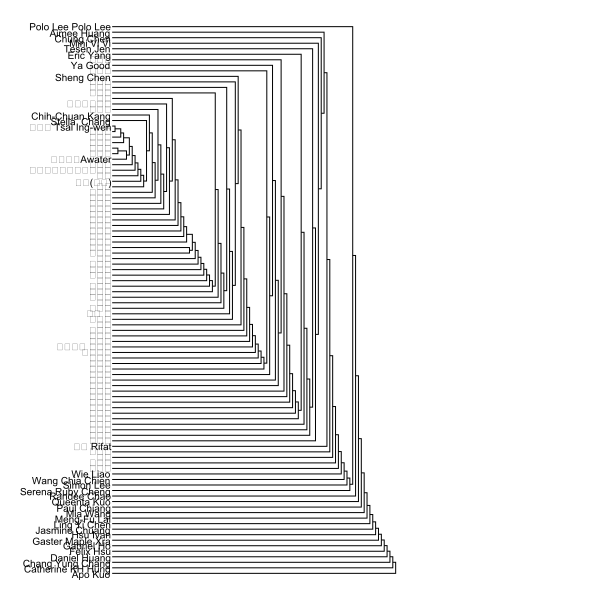

In [15]:
# g.modularity(membership, weights='weight')

modu = sg.community_edge_betweenness(directed=True, weights='weight')
# sg.vs['name']
igraph.plot(modu)

In [14]:
modu.es

AttributeError: 'VertexDendrogram' object has no attribute 'es'

### 鄰居

In [27]:
sg.neighbors('1863023523934803')

[1,
 2,
 3,
 4,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 27,
 28,
 29,
 31,
 32,
 33,
 35,
 39,
 40,
 41,
 42,
 45,
 46,
 47,
 48,
 50,
 51,
 53,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 78,
 80,
 82,
 83,
 84,
 87,
 88,
 90,
 91,
 92,
 94,
 95,
 97]

# ------------- NLP(4mins) -------------
- 處理的流程
> 斷詞 > countvector > topicmodel

## 讀取資料

In [10]:
os.listdir('data/Comments')
comments = pd.concat([pd.read_pickle('data/Comments/Comments_201911.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Comments/Comments_201912.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Comments/Comments_202001.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Replies/Replies201911.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Replies/Replies201912.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']],
                      pd.read_pickle('data/Replies/Replies202001.pkl').loc[:,['NAME','AUTHOR','TIME','TEXT']]],
                    ignore_index=True)
comments = comments.loc[comments['TIME'].between('2019-12-11','2020-01-10',True),:]

# 只保留 KOL 的說話內容
comments = pd.merge(left = comments,
                    right = kols.loc[:,['name']],
                    how = 'left',
                    left_on='AUTHOR',
                    right_on='name',
                    indicator=True)
comments = comments.loc[comments['_merge']=='both',['NAME','AUTHOR','TIME','TEXT']]
print(comments.shape)
comments.head()

(10896, 4)


,NAME,AUTHOR,TIME,TEXT
117,Wang Chia Chien,100001471361107,2019-12-14 16:59,總統投1號
151,Wang Chia Chien,100001471361107,2019-12-14 16:58,沒聲音欸哈
233,蔣兆龍,100002121669552,2019-12-15 03:04,親痛仇快
272,Wang Chia Chien,100001471361107,2019-12-14 16:59,哈哈
304,Wang Chia Chien,100001471361107,2019-12-14 16:58,美人好


In [11]:
comments = comments.groupby(['AUTHOR','NAME'])['TEXT'].apply(lambda x: ' '.join(x)).reset_index()
comments.head(5)

,AUTHOR,NAME,TEXT
0,100000036710110,張百齡,說穿了~就是為了賺人民幣...........\n被解約~少在哪裡裝清高....
1,100000042799436,陳俊吉,"這就叫借題發揮,而掩飾自己無能。\n正所謂上樑不正下樑必歪!\n無需跟對手爭辯對與錯,是與非..."
2,100000106545512,陳冠華,烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑...
3,100000169348902,若絢 閻,所有成功都來自於打破格局\n\n總算有總統不再為了老人的票犧牲年輕人\n打破一代壓榨一代，孩...
4,100000189732330,Queenta Kuo,百年一見政治騙子 一群人生失敗組在這邊教訓年輕人，要我們怎麼信服啦？😂😂😂 一群人生失敗組在...


## 結構化
- 僅保留中文(去除 emuji 、特殊符號)
- 斷詞
- 詞頻矩陣

### 去除標點、特殊符號

In [12]:
# 將非中文的文字、符號替換成空白
comments['TEXT2'] = comments['TEXT'].apply(lambda x: ''.join(re.sub('[^\u4e00-\u9fa5]', ' ', x))) 
comments['TEXT2'] = comments['TEXT2'].apply(lambda x: re.sub('[ ]{1,}', ' ', x))
comments = comments.loc[comments['TEXT2']!='',:]
comments.head(5)

,AUTHOR,NAME,TEXT,TEXT2
0,100000036710110,張百齡,說穿了~就是為了賺人民幣...........\n被解約~少在哪裡裝清高....,說穿了 就是為了賺人民幣 被解約 少在哪裡裝清高 投 號 投 號 中華民國總統 票投 號 ...
1,100000042799436,陳俊吉,"這就叫借題發揮,而掩飾自己無能。\n正所謂上樑不正下樑必歪!\n無需跟對手爭辯對與錯,是與非...",這就叫借題發揮 而掩飾自己無能 正所謂上樑不正下樑必歪 無需跟對手爭辯對與錯 是與非 一起努...
2,100000106545512,陳冠華,烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑市長溜之大吉~酸 烙跑...,烙跑市長溜之大吉 酸 烙跑市長溜之大吉 酸 烙跑市長溜之大吉 酸 烙跑市長溜之大吉 酸 烙跑...
3,100000169348902,若絢 閻,所有成功都來自於打破格局\n\n總算有總統不再為了老人的票犧牲年輕人\n打破一代壓榨一代，孩...,所有成功都來自於打破格局 總算有總統不再為了老人的票犧牲年輕人 打破一代壓榨一代 孩子出生是...
4,100000189732330,Queenta Kuo,百年一見政治騙子 一群人生失敗組在這邊教訓年輕人，要我們怎麼信服啦？😂😂😂 一群人生失敗組在...,百年一見政治騙子 一群人生失敗組在這邊教訓年輕人 要我們怎麼信服啦 一群人生失敗組在這邊教訓...


### 簡體轉繁體
- 有些是單純支持，但有些則在反串
- 說話的內容可以分成哪些主題
    - 主權/草包/加油/。。。
- 透過NLP的分析技術，可以幫助我們了解KOL討論的話題
- 可以標註一下不同KOL討論的話題差異
- 一句話在不同的時間、事件下會有截然不同的意思，要考量整體的環境
    - ex.「唯一支持韓國瑜」
- 把沒有文字的回覆、留言去除掉(只回貼圖的人)


### 斷詞

In [13]:
news = pd.read_csv('keywordsfromnews.csv')
keywords = []
for i in news['KEYWORDS']:
    try:
        keywords += i.split(',', -1)
    except:
        pass

words = ['即將', '辣台派', '英眼部隊', '小英', '拜託','參加','最後','滷肉販', '好朋友','國政','臺灣','樸實無華','副總統','官職','大地震','難聽','賺錢','不知道','扭轉','韓總','一聲令下','使命必達', '藍軍','全壘打',
         '您們','民主退步黨','為國為民','壹週刊','抹紅','民主退步','長相','假掰','先贏再說','韓市長','子虛烏有','愛情摩天輪','彷彿','第十五屆','假民調','機構','說三道四','多說無益','幹你娘', '雞掰','不要臉','乞丐趕廟公',
         '慈善家','苦民所苦','惹毛','在野黨','走私菸','黑韓','流程','正副總統','沒人性','癥結','候選人','產業鏈', '舔共','蔡總統','韓國輸','模稜兩可','政府','憑什麼','憑甚麼','公部門','不懂','白賊義',
         '民進黨','國民黨','台獨','一國兩制','獨立','宋省長','宋先生','宋伯伯','沒錯','網路','棄韓','溜之大吉','當上']

stopwords = ['哈哈', '我們', '小姐', '謝謝', '就是', '可以', '大家', '分享', '很多', '同一', '沒錯','好像','這一', '棒棒', '不用', '目前', '怎樣', '鍵盤', '人物','幫忙','什麼','一定', '沒有', '不要', '真的', '一起',
             '朋友', '加入', '直播', '為了', '檳榔', '這麼多', '晚安', '你們', '自己', '因為', '為何', '阿姨', '不會', '所以', '怎麼', '還是', '這麼', '早安', '一直', '呵呵', '人數', '這邊',  '您們', '好好', '這是', 
            '今天', '只有','多少','為什麼', '一下', '開始', '趕快', '他們', '必須','但是', '小時', '雖然', '覺得', '起來', '會去', '感謝', '時候', '那邊','有沒有','比較','哪裡', '等等','美女','帥哥','這樣','知道','那一',
            '看到']

keywords = list(set(keywords+words+stopwords))
len(keywords)

14635

In [14]:
for i in keywords:
    jieba.add_word(i)
print('Complete!')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TL_Yu\AppData\Local\Temp\jieba.cache
Loading model cost 0.525 seconds.
Prefix dict has been built succesfully.


Complete!


In [15]:
def sent2words(sent):
    words = []
    for i in jieba.lcut(sent):
        if i != ' ':
            if len(i) >= 2:
                if i not in stopwords:
                    words.append(i)
    words = ' '.join(words)
    return  words

In [16]:
comments['TEXT3'] = comments['TEXT2'].apply(lambda x: sent2words(x))

# 去除詞太少的人
# comments['LENG'] = comments['TEXT3'].apply(lambda x: len(x))
# comments.loc[comments['LENG'] < 5,:]
# comments = comments.loc[comments['LENG'] >= 5,:]
# comments['TEXT3'] = comments['TEXT3'].apply(lambda x: ' '.join(x))

print(comments.shape)
comments.head(2)

(96, 5)


,AUTHOR,NAME,TEXT,TEXT2,TEXT3
0,100000036710110,張百齡,說穿了~就是為了賺人民幣...........\n被解約~少在哪裡裝清高....,說穿了 就是為了賺人民幣 被解約 少在哪裡裝清高 投 號 投 號 中華民國總統 票投 號 ...,說穿 人民幣 解約 少在 清高 中華民國 總統 票投 中華民國 總統 票投 艾爾 嘴巴 台灣...
1,100000042799436,陳俊吉,"這就叫借題發揮,而掩飾自己無能。\n正所謂上樑不正下樑必歪!\n無需跟對手爭辯對與錯,是與非...",這就叫借題發揮 而掩飾自己無能 正所謂上樑不正下樑必歪 無需跟對手爭辯對與錯 是與非 一起努...,借題發揮 掩飾 無能 所謂 上樑不正 下樑 必歪 無需 對手 爭辯 努力 捍衛 台灣 主權 ...


In [36]:
# for i, j in zip(comments['TEXT2'],comments['TEXT3']):
#     print(i)
#     print('------')
#     print(j)
#     print('======')

### 詞頻矩陣

In [17]:
# vectorizer = TfidfVectorizer(analyzer='word',       
# #                              max_df=0.95,
#                              min_df=5,                        # minimum reqd occurences of a word 
#                              # max_features=50000,             # max number of uniq words
#                             )

vectorizer = CountVectorizer(analyzer='word',       
                             max_df=90,
                             min_df=10,                        # minimum reqd occurences of a word 
                             lowercase=True# ,                   # convert all words to lowercase
                            )

data_vectorized = vectorizer.fit_transform(comments['TEXT3'])
data_vectorized

<96x331 sparse matrix of type '<class 'numpy.int64'>'
	with 5514 stored elements in Compressed Sparse Row format>

## LDA分析

In [18]:
n_components = 10

In [19]:
%%time
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=n_components,           # Number of topics
                                      max_iter=2000,              # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
#                                       batch_size=128,            # n docs in each learning iter
#                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 3,               
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
# print(lda_model)  # Model attributes

Wall time: 1min 26s


In [20]:
# Create Document - Topic Matrix
# lda_output = best_lda_model.transform(data_vectorized)

# n_components = best_lda_model.n_components

# column names
topicnames = ["Topic" + str(i) for i in range(n_components)]

# index names
docnames = comments['AUTHOR']

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# # Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
df_document_topics = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
AUTHOR,,,,,,,,,,,
100000036710110,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.700000,0.200000,0.010000,7
100000042799436,0.010000,0.180000,0.160000,0.010000,0.010000,0.010000,0.010000,0.180000,0.340000,0.110000,8
100000106545512,0.170000,0.220000,0.000000,0.000000,0.020000,0.000000,0.010000,0.570000,0.000000,0.000000,7
100000169348902,0.010000,0.570000,0.010000,0.010000,0.380000,0.010000,0.010000,0.010000,0.010000,0.010000,1
100000189732330,0.010000,0.950000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1
100000204481509,0.010000,0.130000,0.010000,0.010000,0.010000,0.200000,0.210000,0.430000,0.010000,0.010000,7
100000239611720,0.230000,0.000000,0.440000,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,2
100000319616052,0.080000,0.160000,0.000000,0.000000,0.740000,0.000000,0.000000,0.000000,0.000000,0.000000,4
100000321514132,0.000000,0.240000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.720000,9


In [21]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,支持,唯一,韓國瑜,臺灣,庶民,高雄,韓總,市長,總統,凍蒜
Topic 1,支持,國民黨,台灣,高雄,投票,韓市長,人民,中國,一樣,高雄人
Topic 2,中華民國,韓國瑜,蔡英文,總統,民進黨,下架,主席,宋楚瑜,執政,捍衛
Topic 3,民進黨,台灣,對不起,蔡英文,總統,拒絕,明年,國家,勝利,選舉
Topic 4,台灣,台灣人,民主,小英,總統,中國,香港,自由,國家,加油
Topic 5,民進黨,韓國瑜,下架,蔡英文,人民,國瑜,高雄,總統,挺韓,遊行
Topic 6,蔡英文,小英,博士,論文,總統,台灣,發現,馬英九,現在,問題
Topic 7,草包,市長,總統,韓粉,韓國瑜,票投,人民,不懂,中華民國,高雄
Topic 8,台灣,美國,總統,中國,通過,台灣人,政府,重要,生活,祝福
Topic 9,加油,韓國瑜,總統,支持,韓總,當選,人民,堅定,高票,台灣


In [22]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,28
1,2,13
2,4,10
3,9,9
4,0,9
5,5,7
6,7,6
7,6,6
8,8,5
9,3,3


In [29]:
# 到底小英的高票是因為支持還是因為不喜歡韓??
這邊可以列一些代表性的留言

- Topic0：支持蔡連任
- Topic1：博士學位議題
- Topic2：草包~
- Topic3：國家主權議題
- Topic4：宋楚瑜
- Topic5：支持韓

## 視覺化
- LDA VIS

In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  28.575321
8       0.648955  71.707100       2        1  16.757358
1      71.019684   9.971006       3        1  11.364280
9       3.785981  33.185135       4        1   8.678005
3     -42.666500  -9.222070       5        1   8.293258
2      -3.621689 -43.526516       6        1   7.782970
0      -3.632402  -4.171708       7        1   7.067010
6     -36.584400  35.804413       8        1   4.882390
7      44.391380  50.615383       9        1   4.264330
5      40.235809 -31.591665      10        1   2.335078, topic_info=      Term         Freq        Total Category  logprob  loglift
317    韓國瑜   716.000000   716.000000  Default  30.0000  30.0000
62      加油   542.000000   542.000000  Default  29.0000  29.0000
264    蔡英文   572.000000   572.000000  Default  28.0000  28.0000
84      唯一   300.000000   300.000000  Default  27.0000  27.0000
168     支持   671.000000   671.000000  Default  26.0000  26.0000
201    民進黨   406.000000   406.000000  Default  25.0000  25.0000
260     草包   152.000000   152.000000  Default  24.0000  24.0000
245     總統   892.000000   892.000000  Default  23.0000  23.0000
130     市長   216.000000   216.000000  Default  22.0000  22.0000
79      台灣  1919.000000  1919.000000  Default  21.0000  21.0000
258     臺灣   150.000000   150.000000  Default  20.0000  20.0000
124     小英   363.000000   363.000000  Default  19.0000  19.0000
25    中華民國   358.000000   358.000000  Default  18.0000  18.0000
34      人民   332.000000   332.000000  Default  17.0000  17.0000
11      下架   157.000000   157.000000  Default  16.0000  16.0000
320     韓粉   131.000000   131.000000  Default  15.0000  15.0000
250     美國   245.000000   245.000000  Default  14.0000  14.0000
321     韓總   150.000000   150.000000  Default  13.0000  13.0000
328     高雄   270.000000   270.000000  Default  12.0000  12.0000
80     台灣人   443.000000   443.000000  Default  11.0000  11.0000
22      中國   411.000000   411.000000  Default  10.0000  10.0000
123    對不起   100.000000   100.000000  Default   9.0000   9.0000
234     票投   164.000000   164.000000  Default   8.0000   8.0000
289     通過   169.000000   169.000000  Default   7.0000   7.0000
278     論文   100.000000   100.000000  Default   6.0000   6.0000
161     拒絕   155.000000   155.000000  Default   5.0000   5.0000
66      博士    89.000000    89.000000  Default   4.0000   4.0000
220     當選   151.000000   151.000000  Default   3.0000   3.0000
105     堅定    82.000000    82.000000  Default   2.0000   2.0000
137     庶民    93.000000    93.000000  Default   1.0000   1.0000
0       一國    59.388806    61.672479   Topic1  -4.8484   1.2149
109     大陸    89.055994    99.454299   Topic1  -4.4433   1.1422
209     無法   109.327866   127.224242   Topic1  -4.2382   1.1010
126     崩潰    53.790862    66.252401   Topic1  -4.9474   1.0443
199     民主   268.241132   330.906589   Topic1  -3.3407   1.0427
238     竟然    38.201034    47.672318   Topic1  -5.2897   1.0311
177     政黨   115.895160   147.130871   Topic1  -4.1799   1.0140
182     日本    44.518001    57.604117   Topic1  -5.1366   0.9949
323     香港   179.046432   233.650082   Topic1  -3.7449   0.9864
257     自由   175.335587   229.487908   Topic1  -3.7658   0.9835
87      喜歡    59.342195    79.354238   Topic1  -4.8492   0.9620
24      中華    27.846935    37.678583   Topic1  -5.6058   0.9503
71    反滲透法    69.587313    94.319562   Topic1  -4.6900   0.9485
134     平安    44.609794    60.474293   Topic1  -5.1346   0.9484
117     守護    77.131997   108.378444   Topic1  -4.5870   0.9125
296     選擇    95.634615   136.967010   Topic1  -4.3720   0.8934
218     留言    32.567039    47.539570   Topic1  -5.4492   0.8744
57      別人    42.705625    62.472892   Topic1  -5.1782   0.8722
302     那麼    58.301551    85.415259   Topic1  -4.8669   0.8707
52     共和國    26.235854    38.584996   Topic1  -5.6654   0.8669
16      不管    49.8530

# ------------- NLP _ Topic Model by each comment -------------
這樣可以計算每則留言的討論次數

# ------------- SNA + NLP -------------
- 結合SNA與NLP的成果，我們發現各各社群討論的話題有明顯的差異
- 用 沉浸式簡報的方式，簡單回顧一下KOL們說了些什麼

- NLP與位在網絡核心也會有關係!
- KOL -> Key Opinion Consumer

----
- 韓國瑜陣營能夠製造話題，吸引大家來留言
- 📌但是其中不乏反對他的人
----
- 應用：

SNA 跟 NLP 的疊圖
    

# ------------- SNA的動態觀察 -------------
- 有時間在做!
- [用python分析《三国演义》中的社交网络.ipynb](https://github.com/blmoistawinde/hello_world/blob/master/sanguo_network/用python分析《三国演义》中的社交网络.ipynb)

# ------------- 結語 -------------

- 透過SNA可以找到哪些人位在網絡的核心位置，接著可以透過NLP了解民眾的想法
- KOL 反映了民眾的想法，希望不同陣營的候選人可以針對這些議題正面回應!

- 政治獻金再也不用兩邊押寶(誤
- 不同產業/領域的關聯資料的意義有很大的差異，也不會每個鏈接都有意義。分析者在分析時還是需要結合Domain Knowkedge進行解析
    - 社群： 找出 KOL 幫助行銷
    >  找出 KOL 與KOL的興趣/偏好，避免KOL流失 (做出幾個標籤，怎麼做，怎麼貼)
    - 人資:  離職風險偵測
    - 電信:  流失風險偵測(人)
    - 金融:  偵測異常金流、
    - 客服： 服務流程設計(服務流程), 服務間的關聯，設計最適的服務流程、來電客訴訊號要求減免月租、取消違約金
    - 最後一個留給大家想，如果有任何的討論/建議我都會非常感謝!
> 不管你的身份是想要找到KOL幫你轉播訊息，或者你是分析師想要找到KOL，或者是一般民眾想要識別出真/假的KOL，都希望你會在這場演講中有收穫
> 資料會釋出，有興趣的人可以到以下網址尋找


# QA時間(5分)

# ------------- 潛在提問 -------------
- 網軍議題
> 其實在投稿的時候只是想要認真的用資料聊八卦，結果6月的時候就被罷免，讓這個議題突然變得很敏感。不過就像在前面提到的透過節點重要性的方式可以幫助我們區辨出真正的KOL和網軍。
- 要怎麼選擇filter的critical value
> 這個需要評估你有多少的資源，除了人力，還有你的時間，時間多的話就可以看得多一些。相反的話則看前面就好。畢竟不會每個關聯都很重要。。例如對於金融業在抓異常金流的時候，如果金流只有50/100，顯然就不是這麼重要.

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3       1.465019 -47.625065       1        1  33.488724
2      54.854797 -36.476795       2        1  24.783255
5      32.212929 -61.444572       3        1  16.474535
1       5.111096 -14.110332       4        1  11.705751
0      26.350170 -33.374702       5        1   9.465678
4      38.109818  -7.222781       6        1   4.082057, topic_info=      Term          Freq         Total Category  logprob  loglift
2900   韓國瑜  33702.000000  33702.000000  Default  30.0000  30.0000
1476    支持  27205.000000  27205.000000  Default  29.0000  29.0000
769     唯一  16883.000000  16883.000000  Default  28.0000  28.0000
1776   民進黨  12877.000000  12877.000000  Default  27.0000  27.0000
572     加油  17574.000000  17574.000000  Default  26.0000  26.0000
2375   蔡英文  13500.000000  13500.000000  Default  25.0000  25.0000
701     台灣  25627.000000  25627.000000  Default  24.0000  24.0000
2227    總統  23530.000000  23530.000000  Default  23.0000  23.0000
1096    小英   6108.000000   6108.000000  Default  22.0000  22.0000
1024   宋楚瑜   3182.000000   3182.000000  Default  21.0000  21.0000
1191   張善政   4970.000000   4970.000000  Default  20.0000  20.0000
611     博士   3108.000000   3108.000000  Default  19.0000  19.0000
823     國政   3670.000000   3670.000000  Default  18.0000  18.0000
2130    立委   4855.000000   4855.000000  Default  17.0000  17.0000
1400    投票   3272.000000   3272.000000  Default  16.0000  16.0000
1763    民主   4400.000000   4400.000000  Default  15.0000  15.0000
2751    還是   3528.000000   3528.000000  Default  14.0000  14.0000
2908    韓粉   4196.000000   4196.000000  Default  13.0000  13.0000
40      一樣   2938.000000   2938.000000  Default  12.0000  12.0000
865     堅定   2735.000000   2735.000000  Default  11.0000  11.0000
2689    連任   2368.000000   2368.000000  Default  10.0000  10.0000
199   中華民國   6534.000000   6534.000000  Default   9.0000   9.0000
2327    臺灣   2419.000000   2419.000000  Default   8.0000   8.0000
137     不會   4579.000000   4579.000000  Default   7.0000   7.0000
1811    法案   1327.000000   1327.000000  Default   6.0000   6.0000
2220    網軍   3974.000000   3974.000000  Default   5.0000   5.0000
553    副總統   2520.000000   2520.000000  Default   4.0000   4.0000
2753    還有   3441.000000   3441.000000  Default   3.0000   3.0000
2354    草包   3642.000000   3642.000000  Default   2.0000   2.0000
1930   王小姐   2276.000000   2276.000000  Default   1.0000   1.0000
703    台灣國    789.127818    789.960635   Topic1  -6.3158   1.0929
2952    马洪    587.389818    588.225601   Topic1  -6.6110   1.0925
1681   柯文哲    544.448646    545.282011   Topic1  -6.6870   1.0924
2214    網友    483.529130    484.362029   Topic1  -6.8056   1.0922
627     原因    311.751678    312.587642   Topic1  -7.2445   1.0913
922     大港    293.777107    294.611260   Topic1  -7.3039   1.0911
341     你贏    276.800076    277.633560   Topic1  -7.3634   1.0910
2448    觀看    259.819515    260.655855   Topic1  -7.4267   1.0907
2383    藝人    242.843971    243.678157   Topic1  -7.4943   1.0905
695    台北市    239.847998    240.682092   Topic1  -7.5067   1.0905
555     創新    195.901850    196.739800   Topic1  -7.7091   1.0897
1912    爭議    183.921104    184.755547   Topic1  -7.7722   1.0894
1200    強調    178.927996    179.762108   Topic1  -7.7998   1.0893
2457    計畫    178.923690    179.762099   Topic1  -7.7998   1.0893
354     來自    177.928050    178.763419   Topic1  -7.8054   1.0893
1593    暴徒    177.927228    178.763418   Topic1  -7.8054   1.0893
2646    退休    171.936112    172.771289   Topic1  -7.8396   1.0891
2773    邱毅    170.937579    171.772602   Topic1  -7.8454   1.0891
2135    站台    169.938843    170.773913   Topic1  -7.8513   1.0891
408     債務    166.944815    167.777851   Topic1  -7.8691   1.0890
1707    極權    166.940645    167.777844   Topic1  -7.8691   1.0890
919     大會    156.954632    157.790964   Topic1  -7.9308   1.0886
351     來台 

# 交叉分析
- 組合SNA與LDA的分析結果

In [110]:
df_document_topic.reset_index()

,AUTHOR,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
0,46251501064,0.39,0.00,0.08,0.53,0.00,0.00,3
1,1863023523934803,0.00,0.00,0.50,0.00,0.00,0.49,2
2,100009264227130,0.08,0.07,0.18,0.36,0.00,0.30,3
3,100000364294377,0.05,0.00,0.26,0.65,0.03,0.02,3
4,100005413301437,0.20,0.03,0.41,0.30,0.02,0.04,2
...,...,...,...,...,...,...,...,...
1074,100008169678237,0.00,0.30,0.42,0.19,0.00,0.08,2
1075,100004438576931,0.01,0.14,0.36,0.43,0.01,0.05,3
1076,100042475011195,0.00,0.00,0.99,0.01,0.00,0.00,2
1077,1376293908,0.00,0.04,0.60,0.34,0.02,0.00,2


In [111]:
KOLS.loc[:,['AUTHOR','NAME','Weighted Degree','modularity_class','TEXT','TEXT3']]

,AUTHOR,NAME,Weighted Degree,modularity_class,TEXT,TEXT3
0,46251501064,蔡英文 Tsai Ing-wen,449403,0,大支表演中，總統也即將到場！ 高雄辣台派都到現場了嗎？記得傳line告訴我你在現場！ htt...,大支 表演 中 總統 也 即將 到場 高雄 辣台派 都 到 現場 了 嗎 記得 傳 告訴 我...
1,1863023523934803,韓國瑜,557902,1,大家明天見！\n沒有養寵物也可以一起來拍照做愛心 🥰 大家明天見！\n沒有養寵物也可以一起來...,大家 明天 見 沒有 養 寵物 也 可以 一 起來 拍照 做 愛心 大家 明天 見 沒有 養...
2,100009264227130,張榮發,454,3,在等一位全民總統倒數61天\n#國政領航經濟起飛臺灣💪\n赤子之心樸實無華性格感動\n唯一支...,在 等 一位 全民 總統 倒數 天 國政 領航 經濟 起飛 臺灣 赤子之心 樸實無華 性格 ...
3,100000364294377,陳一惇,144,3,加油加油💪 希望能有辛辣的問題，相信韓總更能發揮，讓誤會您的年輕朋友們眼睛一亮！\n絕對不要...,加油 加油 希望 能 有 辛辣 的 問題 相信 韓總 更能 發揮 讓 誤會 您 的 年輕 朋...
4,100005413301437,Wie Liao,550,4,唯一支持韓國輸 2020落選+罷免 韓國輸的可憐 韓國愉快不起來😫😫 1月你也會在輸一次的 ...,唯一 支持 韓國輸 落選 罷免 韓國輸 的 可憐 韓國 愉快 不 起來 月 你 也 會 在 ...
...,...,...,...,...,...,...
1074,100008169678237,黃玉鳳,111,3,CY Lin 你搞清楚 國小生老師 在課堂上教保險套的使用方法 家長出來陳情 堯轅 四年出來...,你 搞清楚 國 小生 老師 在 課堂 上教 保險套 的 使用 方法 家長 出來 陳 情 堯轅...
1075,100004438576931,黃秀芸,180,3,看到無言...快昏倒..最後笑翻\nhttps://youtu.be/pM3ja10...,看到 無言 快 昏倒 最後 笑 翻 看到 無言 快 昏倒 最後 笑 翻 好 星期一 就 去 ...
1076,100042475011195,黃黎華,271,3,趙羽翼 阿翼.我來助攻嘴綠綠! 梁國謙 黃中信 Phung J Zong 黃中信 黃中信 黃...,趙 羽翼 阿翼 我來 助攻 嘴 綠綠 梁國謙 黃 中信 黃 中信 黃 中信 黃 中信 黃 中...
1077,1376293908,龔文忠,161,4,"去X菊的FB講 拎刀系郎!? 真是萬民擁戴,我在郭,韓的FB看到不少不認同他們的留言,在這裡...",去 菊 的 講 拎 刀 系郎 真是 萬民 擁戴 我 在 郭 韓的 看到 不少 不 認同 他們...


In [112]:
KOLS2 = pd.merge(left=KOLS.loc[:,['AUTHOR','NAME','Weighted Degree','modularity_class','TEXT']],
                 right=df_document_topic.reset_index(),
                 how='left',
                 on='AUTHOR')
KOLS2.head(1000)

,AUTHOR,NAME,Weighted Degree,modularity_class,TEXT,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
0,46251501064,蔡英文 Tsai Ing-wen,449403,0,大支表演中，總統也即將到場！ 高雄辣台派都到現場了嗎？記得傳line告訴我你在現場！ htt...,0.39,0.00,0.08,0.53,0.00,0.00,3
1,1863023523934803,韓國瑜,557902,1,大家明天見！\n沒有養寵物也可以一起來拍照做愛心 🥰 大家明天見！\n沒有養寵物也可以一起來...,0.00,0.00,0.50,0.00,0.00,0.49,2
2,100009264227130,張榮發,454,3,在等一位全民總統倒數61天\n#國政領航經濟起飛臺灣💪\n赤子之心樸實無華性格感動\n唯一支...,0.08,0.07,0.18,0.36,0.00,0.30,3
3,100000364294377,陳一惇,144,3,加油加油💪 希望能有辛辣的問題，相信韓總更能發揮，讓誤會您的年輕朋友們眼睛一亮！\n絕對不要...,0.05,0.00,0.26,0.65,0.03,0.02,3
4,100005413301437,Wie Liao,550,4,唯一支持韓國輸 2020落選+罷免 韓國輸的可憐 韓國愉快不起來😫😫 1月你也會在輸一次的 ...,0.20,0.03,0.41,0.30,0.02,0.04,2
5,100000404266312,Felix Hsu,957,4,https://www.facebook.com/100000404266312/posts...,0.07,0.03,0.42,0.46,0.00,0.03,3
6,100004722182299,劉斗,11341,4,我真替 打虎英雄 前台北縣長 周先生 感到 氣憤，為了國瑜兄拼了那麼久了，結果副總統是別人，...,0.01,0.03,0.58,0.21,0.02,0.15,2
7,100037613541194,張愷君,701,4,從來沒看過這麼低俗的候選人，心裏一直想著潘金蓮， 難怪加分要出來說x交跟×...,0.06,0.00,0.69,0.25,0.00,0.00,2
8,100002448422154,簡明德,330,3,堅定不移 挺我兄弟🇹🇼 堅定不移 挺我兄弟 !! 堅定不移 挺我兄弟 !! 賴功德說：「最黑...,0.00,0.27,0.07,0.19,0.04,0.43,5
9,100000126832450,郭子祥,187,4,可能宿醉還沒退 因該差不多知道自己選不上 先找好台階讓自己下🥺🥺🥺 不是老店一間接著一間倒嗎...,0.02,0.02,0.92,0.02,0.02,0.02,2


In [114]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,台灣,小英,總統,加油,投票,臺灣,連任,蔡英文,民主,我們,大家,選票,一定,王小姐,香港,要贏,過半,支持,立委,呂玉彥
Topic 1,蔡英文,博士,民進黨,台灣,網軍,還有,政府,人民,沒有,民主,下台,論文,總統,可以,公投,什麼,土地,台灣人,自己,私菸
Topic 2,韓國瑜,自己,什麼,韓粉,草包,不要,你們,高雄,真的,市長,可以,沒有,不是,就是,支持,我們,總統,一個,不會,出來
Topic 3,台灣,國民黨,民進黨,總統,中國,就是,我們,中華民國,國家,韓國瑜,沒有,不是,你們,人民,什麼,中共,可以,一個,現在,自己
Topic 4,民進黨,宋楚瑜,法案,親民黨,藍綠,立委,一樣,還是,主席,機會,服務,不會,台灣,百姓,包含,條例,通過,現在,幫忙,不是
Topic 5,韓國瑜,支持,唯一,加油,總統,張善政,國政,台灣,中華民國,當選,下架,堅定,我們,庶民,副總統,人民,大家,市長,凍蒜,韓總


In [115]:
KOLS2.to_pickle(path+'InterActive/KOLS2_Ana.pickle')

In [116]:
import prince

In [124]:
caplot=KOLS2.groupby(['modularity_class','dominant_topic']).size().reset_index()
caplot.columns=['modularity_class','dominant_topic','Freq']
caplot = caplot.pivot_table(index='modularity_class',columns='dominant_topic',values='Freq',fill_value=0)
caplot

dominant_topic,0,1,2,3,4,5
modularity_class,,,,,,
0,78,20,40,114,3,10
1,19,1,164,74,1,244
2,4,1,5,14,6,0
3,2,2,71,36,0,36
4,1,3,104,20,0,2
5,0,0,6,0,0,0


In [127]:
ca = prince.CA(n_components=2,
               n_iter=3,
               copy=True,
               check_input=True,
               engine='auto',
               random_state=42)
caplot.columns.rename('dominant_topic', inplace=True)
caplot.index.rename('modularity_class', inplace=True)
ca = ca.fit(caplot)

C:\ProgramData\Anaconda3\lib\site-packages\prince\ca.py:99: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(X, pd.SparseDataFrame):
C:\ProgramData\Anaconda3\lib\site-packages\prince\ca.py:124: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(X, pd.SparseDataFrame):


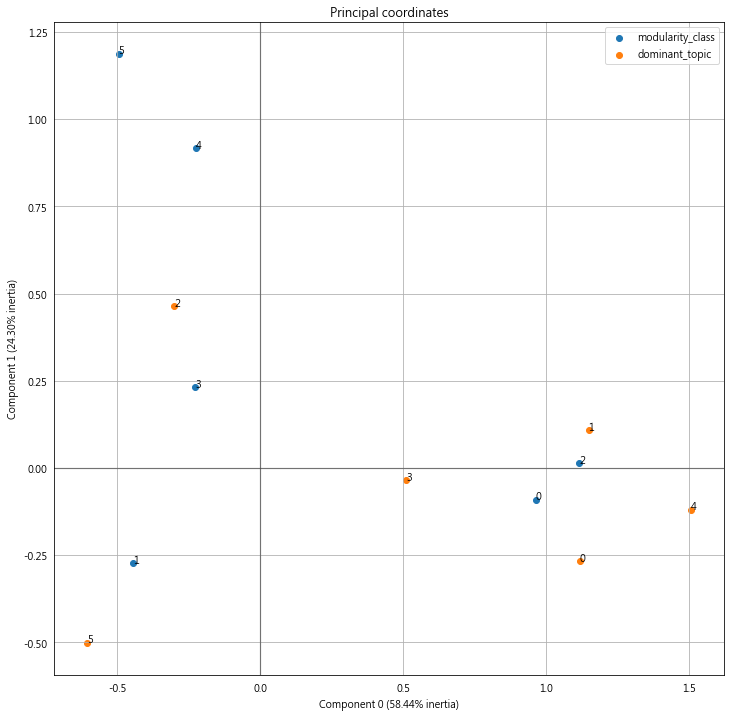

In [129]:
ax = ca.plot_coordinates(X=caplot,
                         ax=None,
                         figsize=(12, 12),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)
ax

- 社群
 - 0：單純蔡
 - 1：單純韓
 - 2：宋楚瑜
 - 3：韓的中介橋樑
 - 4：蔡粉絲跑去韓吵架

 - 5：??
- 議題
 - Topic0：支持蔡連任
 - Topic1：博士學位議題
 - Topic2：帶職參選、草包~
 - Topic3：國家主權議題
 - Topic4：宋楚瑜
 - Topic5：支持韓
 
 - 老跑、香港、被抹黑...

# 追蹤留言

In [4]:
comments = pd.concat([pd.read_pickle('data/Comments/Comments_201911.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Comments/Comments_201912.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Comments/Comments_202001.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Replies/Replies201911.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Replies/Replies201912.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']],
                      pd.read_pickle('data/Replies/Replies202001.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']]],
                    ignore_index=True)
comments# = comments.loc[comments['TIME'].between('2019-11-11','2020-01-10',True),:]

,NAME,AUTHOR,TIME,TEXT,COMMENTID
0,Huang Yin Ping,100004424286384,2019-12-02 15:30,雙主菜便當好吃嗎？雙主菜便當吃飽未？新潮流真下流！吃飽未？2020唯一下架蔡英文跟民進皇奴黨...,101842097936907
1,陳保華,100015698444643,2019-12-04 10:17,用台湾人自己的鮮血和幸福為英帝美霸當先鋒，匪夷所思！,529278834596050
2,洪永芳,100004473915761,2019-12-08 00:46,總統加油,545443076238136
3,蘇麗蓉,100000111917543,2019-12-04 20:30,套一句我2歲10個月的女兒說的：亂七八糟⋯⋯,2686210901471145
4,Kris Lin,100000114647292,2019-12-02 12:27,拐著彎說自己曾經是太監，這麼奇怪的自白我是第一次聽說。,209413813407259
...,...,...,...,...,...
2099367,林長達,100024266227243,2020-01-01 16:09,洪福,1003972719988698
2099368,Linda Sun,1795806447,2020-01-01 19:53,#選賢與能唯一支持宋楚瑜……👍👍👍,1004133646639272
2099369,洪福,100001516854904,2020-01-01 15:57,Faithé Lin \n棄宋保韓💪,1003964956656141
2099370,Faithé Lin,100001356544967,2020-01-01 22:00,洪福 韓草包沒能力,1004236113295692


In [5]:
comments = pd.read_pickle('data/Comments/Comments_201911.pkl').loc[:,['NAME', 'AUTHOR', 'TIME', 'TEXT','COMMENTID']]
comments.loc[comments['NAME']=='徐嘉苧',]

# Comments.loc[Comments['SOURCE_NAME']=='徐嘉苧',:]

,NAME,AUTHOR,TIME,TEXT,COMMENTID
804456,徐嘉苧,100003799310172,2019-11-02 09:59,谁理你：一个公投过了不执行的人跟我谈民意；一个逢美日必跪的人跟我谈尊严；一个自愿慰安的人跟我...,10156191323926065
847487,徐嘉苧,100003799310172,2019-11-19 14:49,菜菜子就是典型只会说大话的政客，充分发扬了呆蛙的优良传统-诈骗之光！,106986020669032
849090,徐嘉苧,100003799310172,2019-11-19 14:50,罪有英德！O(∩_∩)O哈哈~,10156234130331065
860645,徐嘉苧,100003799310172,2019-11-25 16:36,谁理你：一个公投过了不执行的人跟我谈民意；一个逢美日必跪的人跟我谈尊严；一个自愿慰安的人跟我...,10156248333171065
4520973,徐嘉苧,100003799310172,2019-11-14 21:19,如果韩国瑜上台，民进党一定要发动学生再来一次太阳花啊，因为国民党都支持啊！,582254499204767
4523629,徐嘉苧,100003799310172,2019-11-14 21:13,作为中国人，唯一支持蔡英文，宁要真小人，不要伪君子！,460211284624201


In [14]:
# 讀取回覆資料
files = os.listdir('data/Replies')
Replies = []
for i in files:
    ndf = pd.read_pickle('data/Replies/'+ i)
    ndf = ndf.loc[:,['NAME', 'AUTHOR', 'TIME', 'PARENTCOMMENTID','TEXT']]
    gc.collect()
    print(i, ndf.shape)
    Replies.append(ndf)
Replies = pd.concat(Replies, ignore_index=True)
Replies.columns = ['SOURCE_NAME', 'SOURCE', 'TIME', 'PARENTCOMMENTID','TEXT']
Replies['PARENTCOMMENTID'] = Replies['PARENTCOMMENTID'].apply(lambda x: x.split('_',-1)[-1])
Replies = Replies.drop_duplicates(keep='first')
print(Replies.shape)

Replies201901.pkl (60392, 5)
Replies201902.pkl (40896, 5)
Replies201903.pkl (62983, 5)
Replies201904.pkl (78545, 5)
Replies201905.pkl (94891, 5)
Replies201906.pkl (159674, 5)
Replies201907.pkl (83711, 5)
Replies201908.pkl (121623, 5)
Replies201909.pkl (100832, 5)
Replies201910.pkl (164424, 5)
Replies201911.pkl (166414, 5)
Replies201912.pkl (234096, 5)
Replies202001.pkl (211280, 5)
Replies202002.pkl (71839, 5)
Replies202003.pkl (75284, 5)
Replies202004.pkl (22647, 5)
(1690033, 5)


In [15]:
Replies.loc[Replies['SOURCE_NAME']=='艾莉緹',:] 

,SOURCE_NAME,SOURCE,TIME,PARENTCOMMENTID,TEXT
1508407,艾莉緹,100019847109025,2020-01-06 11:59,178758146562858,真的我也有去
1511900,艾莉緹,100019847109025,2020-01-11 21:00,1246434138893413,總統晚安😍
1571175,艾莉緹,100019847109025,2020-01-06 10:50,206364747201036,昨天至少有去台南造勢
1571176,艾莉緹,100019847109025,2020-01-06 10:50,206364747201036,新營賴清德會去羨慕
